In [1]:
# this makes sure updates to the .py files are imported to here, without having to reexcicute the import cell
%load_ext autoreload 
%autoreload 2


# reading training data

# def read_data_to_list(prefixes):
#     data_out = []
#     labs_out = []
#     os.chdir(data_folder)
#     for file in os.listdir():
#         if file[0] in prefixes:
#             path = f"{data_folder}/{file}"
#             with open(path, 'rb') as f:
#                 data_out.append(np.load(f))
    
#     os.chdir(labs_folder)
#     for file in os.listdir():
#         if file[0] in prefixes:
#             path = f"{labs_folder}/{file}"
#             with open(path, 'rb') as f:
#                 labs_out.append(np.load(f))
                
#     return data_out, labs_out
    

In [2]:
# https://medium.com/analytics-vidhya/pytorch-for-deep-learning-lstm-for-sequence-data-d0708fdf5717

import numpy as np
from matplotlib import pyplot as plt
import os
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
from tqdm import tqdm

import torch.multiprocessing as mp

# imports from my files
from VoiceData import VoiceDataSet
from LSTM import LSTM_network
from FFNN import FFNN_network




torch.manual_seed(42)

In [3]:

data_folder = "/Users/will/Documents/COM4511/ass/COM4511/task4VAD/audio"
labs_folder = "/Users/will/Documents/COM4511/ass/COM4511/task4VAD/labels"

training_prefixes = ["N", "V"]
validation_prefixes = ["E"]
testing_prefixes = ["C"]


def calc_means_std(prefixes):
    a_paths, l_paths = VoiceDataSet.gen_paths(VoiceDataSet,prefixes=prefixes)
    a_data, l_data = [], []
    
    for a, l in zip(a_paths, l_paths):
        temp_d, temp_l = VoiceDataSet.read_data_from_path(VoiceDataSet, a, l)
        a_data.append(temp_d)
    
    total_data = torch.cat(a_data)
    
    stds, means = torch.std_mean(total_data, dim=0)
    
    return stds, means
    
    
training_stds, training_means = calc_means_std(training_prefixes)

norm_transform = transforms.Compose([
    transforms.Normalize(training_means, training_stds)]
)

    


In [4]:



window_length = 512

VDS = VoiceDataSet("train", window_length=window_length, transform=norm_transform)

b_size = 8

train_loader = DataLoader(VDS, shuffle=True, batch_size=b_size)


In [46]:
from tqdm import tqdm

#training løøp

model = LSTM_network(hidden_size=26, hidden_layers=2, bidirectional=True)
crit = nn.BCELoss() # binary classfication task, BCEL is obvious choice.
optimiser = optim.Adam(model.parameters(), lr=1e-4 , betas = [0.9, 0.99])#0.00001) 
# classifer = 
#
eps = 1e-7
epochs = 100
losses = [0.1]

train_loader.dataset.win = 5000
dat_len = len(train_loader.dataset)

# dat_len=8096
test_win_len = 8096
dev_X, dev_y = next(iter(DataLoader(VoiceDataSet("val", transform=norm_transform, window_length=8096))))

print(dev_X.shape)
dev_x = dev_X[0, 0:-1, :]
dev_y = dev_y[0, 0:-1, :]
print(dev_x.shape)
train_loader.dataset.win = window_length

t =tqdm(range(epochs))
for e in t:
    epoch_loss = 0
    for i, (X, y) in enumerate(train_loader):
        y_pred = model(X)
        
        optimiser.zero_grad()
        loss = crit(y_pred, y)
        
        loss.backward()
        optimiser.step()
        
        dev_pred = model(dev_x.unsqueeze(0))
        
        epoch_loss += crit(dev_pred.squeeze(0), dev_y)
        
    if e % 1 == 0:    
        epoch_loss /=  dat_len
        losses.append(epoch_loss)
        t.set_description(desc=f"Epoch: {e + 1}, loss: {round(epoch_loss.item(), 5)}")
        
    if abs(losses[-1] - losses[-2]) < eps:
        print("Converged!")
        break
 

torch.Size([1, 8096, 13])
torch.Size([8095, 13])


Epoch: 5, loss: 0.11636:   6%|▌         | 6/100 [00:18<04:46,  3.05s/it]


KeyboardInterrupt: 

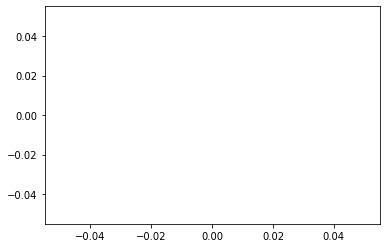

In [ ]:
if losses[0] == 0.1: losses.remove(0.1)
plt.plot([l.item() for l in losses])
# plt.yscale('log')
plt.show()

In [ ]:
from VoiceData import VoiceDataSet

import tqdm
VDS = VoiceDataSet("test", window_length=0, transform=norm_transform)

test_loader = DataLoader(VDS, shuffle=True, batch_size=1)

for i, (X, y) in enumerate(test_loader):
    
    with torch.no_grad():
        y_pred = model(X)
        
        y_pred = np.array(y_pred.squeeze())
        y = np.array(y.squeeze())
        
        
        fpr, tpr, threshold = roc_curve(y, y_pred, pos_label=1)
        fnr = 1 - tpr
        eer_threshold = threshold[np.nanargmin(np.absolute((fnr - fpr)))]
        EER = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
        print(EER)

In [9]:
### FFNN


print([l for l in range(11, 2, -1)])
model = FFNN_network(hidden_dims=[28, 26])

crit = nn.BCELoss() # binary classfication task, BCEL is obvious choice.
optimiser = optim.Adam(model.parameters(), lr=8e-4 , betas = [0.9, 0.99])#0.00001) 
# classifer = 
#
eps = 1e-8
epochs = 1000
# losses = [0.1]
dev_losses = []
tr_losses = []
preds = []


train_loader.dataset.win = 5000
dat_len = len(train_loader.dataset)

# dat_len=8096
test_win_len = 32768
dev_X, dev_y = next(iter(DataLoader(VoiceDataSet("val", transform=norm_transform, window_length=test_win_len)))) # acquire dev sample for loss calculation

print(dev_X.shape)
dev_x = dev_X[0, 0:-1, :]
dev_y = dev_y[0, 0:-1, :]
print(dev_x.shape)
train_loader.dataset.win = 8096 * 2
change = 0
t =tqdm(range(epochs))
for e in t:
    epoch_tr_loss = 0
    epoch_dev_loss = 0
    for i, (X, y) in enumerate(train_loader):
        y_pred = model(X)
        
        optimiser.zero_grad()
        loss = crit(y_pred, y)
        epoch_tr_loss += loss.item()
        loss.backward()
        optimiser.step()
        
        dev_pred = model(dev_x.unsqueeze(0))
        
        epoch_dev_loss += crit(dev_pred.squeeze(0), dev_y).item()
        
    if e % 1 == 0:    
        epoch_dev_loss /=  dat_len
        epoch_tr_loss /= dat_len
        dev_losses.append(epoch_dev_loss)
        tr_losses.append(epoch_tr_loss)
        if len(dev_losses) > 1: change = dev_losses[-2] - dev_losses[-1]
        t.set_description(desc=f"Epoch: {e}, dev loss: {round(epoch_dev_loss, 5)}, tr loss: {round(epoch_tr_loss, 5)}, dev change: {change}")
        
    if len(dev_losses) > 1 and abs(dev_losses[-1] - dev_losses[-2]) < eps:
        print("Converged!")
        print(dev_losses)
        break
 

[11, 10, 9, 8, 7, 6, 5, 4, 3]
torch.Size([1, 32768, 13])
torch.Size([32767, 13])


Epoch: 307, dev loss: 0.01445, tr loss: 0.02388, dev change: 9.03245649839686e-05:  31%|███       | 308/1000 [02:15<05:04,  2.27it/s]   


KeyboardInterrupt: 

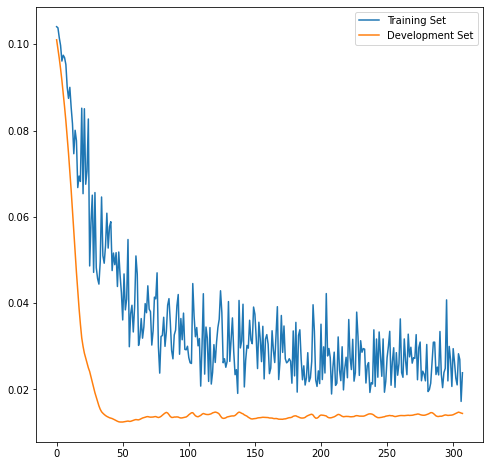

In [10]:

plt.figure(figsize=(8, 8))
plt.plot(tr_losses, label="Training Set")
plt.plot(dev_losses, label="Development Set")

plt.legend()

# plt.yscale('log')
plt.show()

In [11]:
from sklearn.metrics import roc_curve


In [39]:
from VoiceData import VoiceDataSet

import tqdm
VDS = VoiceDataSet("test", window_length=0, transform=norm_transform)

test_loader = DataLoader(VDS, shuffle=True, batch_size=1)

for i, (X, y) in enumerate(test_loader):
    
    with torch.no_grad():
        y_pred = model(X)
        
        y_pred = np.array(y_pred.squeeze())
        y = np.array(y.squeeze())
        
        
        fpr, tpr, threshold = roc_curve(y, y_pred, pos_label=1)
        fnr = 1 - tpr
        eer_threshold = threshold[np.nanargmin(np.absolute((fnr - fpr)))]
        EER = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
        print(EER)

test
0.19990969687942206
0.29086079480812416
